### Importing our libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import rc
from pylab import rcParams
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM

In [2]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 22
np.random.seed(RANDOM_SEED)

In [ ]:
###########################################################################
#Data Source: https://www.investing.com/currencies/eur-usd-historical-data#
###########################################################################

In [3]:
df = pd.read_csv('EUR_USD.csv', parse_dates=['Date'])
df = df.sort_values('Date')
df.tail(10)

,Date,Price,Open,High,Low,Change %
9,2018-02-19,1.2408,1.2409,1.2435,1.2368,0.02%
8,2018-02-20,1.2338,1.2409,1.2414,1.2320,-0.56%
7,2018-02-21,1.2284,1.2338,1.2361,1.2281,-0.44%
6,2018-02-22,1.2331,1.2283,1.2354,1.2260,0.38%
5,2018-02-23,1.2293,1.2329,1.2337,1.2279,-0.31%
4,2018-02-26,1.2318,1.2299,1.2356,1.2278,0.20%
3,2018-02-27,1.2232,1.2317,1.2348,1.2221,-0.70%
2,2018-02-28,1.2194,1.2232,1.2243,1.2188,-0.31%
1,2018-03-01,1.2268,1.2193,1.2272,1.2153,0.61%
0,2018-03-02,1.2317,1.2266,1.2336,1.2250,0.40%


In [4]:
df.head(10)

,Date,Price,Open,High,Low,Change %
4999,1999-01-04,1.1827,1.1742,1.1909,1.1698,0.89%
4998,1999-01-05,1.1764,1.1833,1.1869,1.1725,-0.53%
4997,1999-01-06,1.1618,1.1764,1.1816,1.1553,-1.24%
4996,1999-01-07,1.1709,1.1627,1.1770,1.1608,0.78%
4995,1999-01-08,1.1575,1.1716,1.1738,1.1537,-1.14%
4994,1999-01-11,1.1502,1.1568,1.1610,1.1488,-0.63%
4993,1999-01-12,1.1572,1.1504,1.1576,1.1443,0.61%
4992,1999-01-13,1.1673,1.1573,1.1793,1.1551,0.87%
4991,1999-01-14,1.1698,1.1671,1.1730,1.1612,0.21%
4990,1999-01-15,1.1557,1.1684,1.1751,1.1553,-1.21%


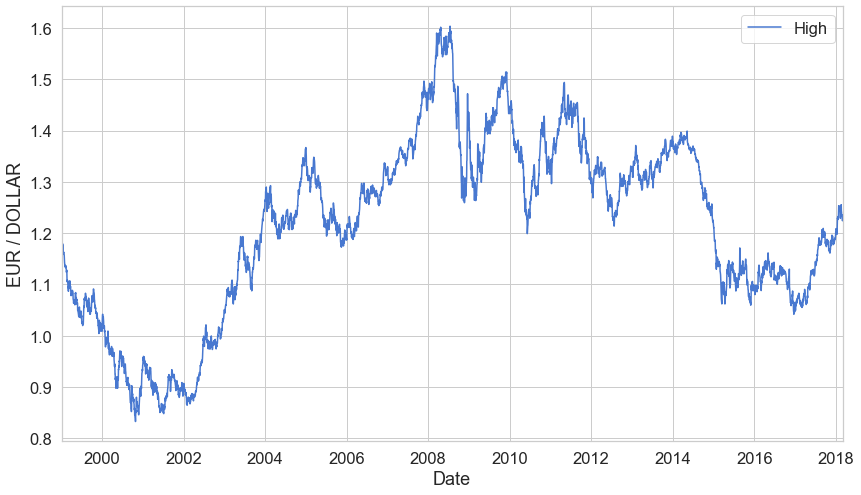

In [5]:
ax = df.plot(x='Date', y='High');
ax.set_xlabel("Date")
ax.set_ylabel("EUR / DOLLAR")
plt.show()

### Scale the data to fit our model

In [6]:
#DOLAR_SELL
scaler = MinMaxScaler()
euro_dollar = df.High.values.reshape(-1, 1)
scaled_euro_dollar = scaler.fit_transform(euro_dollar)

### Check the data if there are NaN values

In [7]:
scaled_euro_dollar.shape
np.isnan(scaled_euro_dollar).any()

False

In [8]:
scaled_euro_dollar = scaled_euro_dollar[~np.isnan(scaled_euro_dollar)]
scaled_euro_dollar = scaled_euro_dollar.reshape(-1, 1)

In [9]:
np.isnan(scaled_euro_dollar).any()

False

In [10]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

In [11]:
def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = preprocess(scaled_euro_dollar, SEQ_LEN, train_split = 0.95)
print("Training Data Size: ", X_train.shape, "Test Data Size: ", X_test.shape)


Training Data Size:  (4655, 99, 1) Test Data Size:  (245, 99, 1)


In [13]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

### Building the model

- Here we first check if your device has GPU or not
- If free GPU(s) are available, then we structure the model with CUDA environment
- For CUDA env, CuDNNLSTM is used
- For CPU env, LSTM model is used

In [15]:
if tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None):
    
    model = keras.Sequential()

    model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                            input_shape=(WINDOW_SIZE, X_train.shape[-1])))
    model.add(Dropout(rate=DROPOUT))

    model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))

    model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

    model.add(Dense(units=1))

    model.add(Activation('linear'))
    
    
else:
    model = keras.Sequential()
    #Adding the first Bidirectional-LSTM layer and some Dropout regularisation
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                            input_shape=(WINDOW_SIZE, X_train.shape[-1])))
    model.add(Dropout(rate=DROPOUT))


    # Adding a second Bidirectional-LSTM layer and some Dropout regularisation
    model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))

    # Adding a third Bidirectional-LSTM layer and some Dropout regularisation
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

    # Adding a final dense layer and linear layer as activation 
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    

### Compile the model

In [16]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

# Start training
- Here you can define different parameters and train few models to see the performances

In [17]:
BATCH_SIZE = 64

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=BATCH_SIZE, 
                    shuffle=False,
                    validation_split=0.1)

Epoch 1/50
66/66 [==============================] - 32s 395ms/step - loss: 0.0191 - val_loss: 0.0059
Epoch 2/50
66/66 [==============================] - 26s 389ms/step - loss: 0.0190 - val_loss: 0.0168
Epoch 3/50
66/66 [==============================] - 26s 395ms/step - loss: 0.0192 - val_loss: 0.0102
Epoch 4/50
66/66 [==============================] - 25s 383ms/step - loss: 0.0162 - val_loss: 0.0071
Epoch 5/50
66/66 [==============================] - 25s 385ms/step - loss: 0.0089 - val_loss: 0.0061
Epoch 6/50
66/66 [==============================] - 25s 382ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 7/50
66/66 [==============================] - 26s 394ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 8/50
66/66 [==============================] - 26s 396ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 9/50
66/66 [==============================] - 26s 399ms/step - loss: 0.0011 - val_loss: 3.3490e-04
Epoch 10/50
66/66 [==============================] - 26s 389ms/step - loss: 6.9772e-04 

In [18]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 73ms/step - loss: 7.0143e-04


0.0007014265866018832

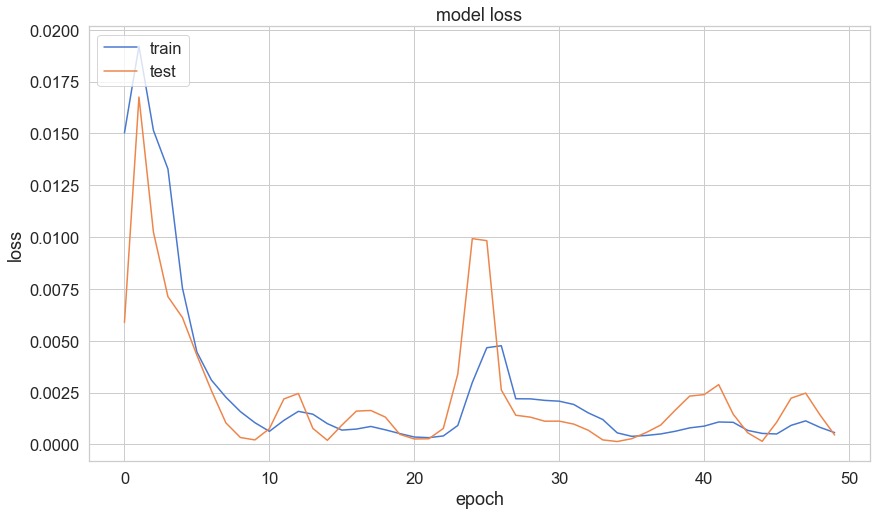

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Run the model on the test data that model has not seen yet

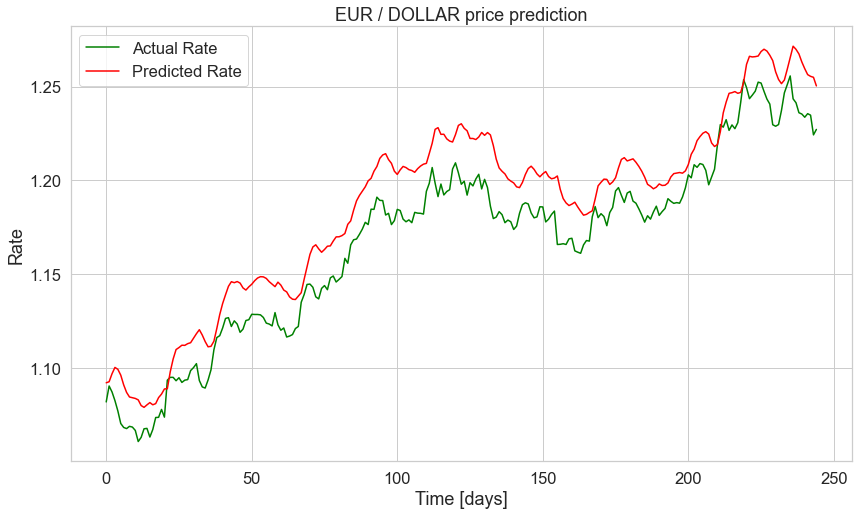

In [20]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Rate", color='green')
plt.plot(y_hat_inverse, label="Predicted Rate", color='red')
 
plt.title('EUR / DOLLAR price prediction')

plt.xlabel('Time [days]')
plt.ylabel('Rate')
plt.legend(loc='best')
 
plt.show();

### Save the model

In [21]:
model.save('eur_dollar.h5')

### Load the model to use for further analysis

In [ ]:
model = load_model('eur_dollar.h5')